In [1]:
import mne
from mne.datasets import eegbci
from mne.io import read_raw_edf
import numpy as np
import pandas as pd
import tensorflow as tf
np.random.seed(42)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, BatchNormalization, Conv2D
from keras.layers import Reshape, Permute, ZeroPadding2D
from keras.layers import MaxPooling2D

Using TensorFlow backend.


In [2]:
subjects = range(1,110)
runs = [1,2] # Baseline: Eyes open vs eyes closed

raw_fnames = list()
for subject in subjects: 
    raw_fnames.append(eegbci.load_data(subject, runs))
    
# We now need to flatten the list
flat_list = [item for sublist in raw_fnames for item in sublist]

raw_files = [read_raw_edf(f, preload=True, stim_channel='auto') for f in flat_list]

pd.set_option('display.max_colwidth', -1)

df = pd.DataFrame(raw_fnames)
df = df.rename(columns={0: "Eyes_Open", 1: "Eyes_Closed"})

raw_files_open = [read_raw_edf(f, preload=True, stim_channel='auto') for f in df.Eyes_Open]
raw_files_closed = [read_raw_edf(f, preload=True, stim_channel='auto') for f in df.Eyes_Closed]

# The events are spaced evenly every 1 second.
duration = 1.
event_id_o = 1 # Eyes open
event_id_c = 0 # Eyes closed

# for fixed size events no start time before and after event
tmin = 0.
tmax = 0.99  # inclusive tmax, 1 second epochs


# create a fixed size events array
# start=0 and stop=None by default


# Get all the open events

temp_o = []

for raw_ in raw_files_open:    
    events_o = mne.make_fixed_length_events(raw_, event_id_o, duration=duration)
    # create :class:`Epochs <mne.Epochs>` object
    epochs_o = mne.Epochs(raw_, events=events_o, event_id=event_id_o, tmin=tmin,
                        tmax=tmax, baseline=None, verbose=True)
    for ep in epochs_o:
        temp_o.append(ep)

big_raw_o = np.array(temp_o)

# Get all the open events


temp_c = []

for raw_ in raw_files_closed:    
    events_c = mne.make_fixed_length_events(raw_, event_id_c, duration=duration)
    # create :class:`Epochs <mne.Epochs>` object
    epochs_c = mne.Epochs(raw_, events=events_c, event_id=event_id_c, tmin=tmin,
                        tmax=tmax, baseline=None, verbose=True)
    for ep in epochs_c:
        temp_c.append(ep)

big_raw_c = np.array(temp_c)

labels_o = np.ones(len(big_raw_o))
labels_c = np.zeros(len(big_raw_c))

big_raw = np.concatenate((big_raw_o[:, :-1, :], big_raw_c[:, :-1, :]), axis=0)
big_labels = np.concatenate((labels_o, labels_c), axis=0)

# preprocess dataset, split into training and test part
X, y = big_raw, big_labels

Extracting edf Parameters from /Users/axeluran/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Ready.
Extracting edf Parameters from /Users/axeluran/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R02.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Ready.
Extracting edf Parameters from /Users/axeluran/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S002/S002R01.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Ready.
Extracting edf Parameters from /Users/axeluran/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S002/S002R02.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Re

In [3]:
X_3D_train, X_3D_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)

X_3D_train = X_3D_train.reshape(X_3D_train.shape[0], 1, 64, 159)
X_3D_test = X_3D_test.reshape(X_3D_test.shape[0], 1, 64, 159)

y_train = np_utils.to_categorical(y_train, 2)
y_test = np_utils.to_categorical(y_test, 2)


# EEGnet model
EEGnet = Sequential()

# Layer 1
EEGnet.add(Conv2D(input_shape=(1,64,159), filters=16, kernel_size=(64, 1), data_format='channels_first'))
EEGnet.add(BatchNormalization(axis=1))
EEGnet.add(Permute((2,1,3), input_shape=(16,1,159)))
EEGnet.add(Dropout(.25))

# Padding to get N % 4
EEGnet.add(ZeroPadding2D(padding=((0,1), (16,17)), data_format="channels_first"))

# Layer 2
EEGnet.add(Conv2D(filters=4, kernel_size=(2, 32), activation='relu', data_format='channels_first'))
EEGnet.add(BatchNormalization(axis=1))
EEGnet.add(MaxPooling2D(pool_size=(2,4), data_format='channels_first'))
EEGnet.add(Dropout(0.25))

# Padding to get N % 4
EEGnet.add(ZeroPadding2D(padding=((4,3), (2,1)), data_format="channels_first"))

# Layer 3
EEGnet.add(Conv2D(filters=4, kernel_size=(8, 4), activation='relu', data_format='channels_first'))
EEGnet.add(BatchNormalization(axis=1))
EEGnet.add(MaxPooling2D(pool_size=(2,4), data_format='channels_first'))
EEGnet.add(Dropout(0.25))


# Layer 4
EEGnet.add(Flatten())
EEGnet.add(Dense(2, activation='softmax'))

EEGnet.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

EEGnet.fit(X_3D_train, y_train, 
          batch_size=32, epochs=10, verbose=1)

score = EEGnet.evaluate(X_3D_test, y_test, batch_size=32)

print(score)

Epoch 1/10
7975/7975 [==============================] - 32s - loss: 0.6702 - acc: 0.5794      

In [88]:
def EEG_Model(n_channels, n_timestamps): 
    # EEGnet model
    EEGnet = Sequential()

    # Layer 1
    EEGnet.add(Conv2D(input_shape=(1,n_channels,n_timestamps), filters=16, kernel_size=(n_channels, 1), data_format='channels_first'))
    EEGnet.add(BatchNormalization(axis=1))
    EEGnet.add(Permute((2,1,3), input_shape=(16,1,159)))
    EEGnet.add(Dropout(.25))

    
    # Padding to get N % 4
    EEGnet.add(ZeroPadding2D(padding=((0,1), (16,17)), data_format="channels_first"))

    # Layer 2
    EEGnet.add(Conv2D(filters=4, kernel_size=(2, 32), activation='relu', data_format='channels_first'))
    EEGnet.add(BatchNormalization(axis=1))
    EEGnet.add(MaxPooling2D(pool_size=(2,4), data_format='channels_first'))
    EEGnet.add(Dropout(0.25))

    # Padding to get N % 4
    EEGnet.add(ZeroPadding2D(padding=((4,3), (2,1)), data_format="channels_first"))

    # Layer 3
    EEGnet.add(Conv2D(filters=4, kernel_size=(8, 4), activation='relu', data_format='channels_first'))
    EEGnet.add(BatchNormalization(axis=1))
    EEGnet.add(MaxPooling2D(pool_size=(2,4), data_format='channels_first'))
    EEGnet.add(Dropout(0.25))

    # Layer 4
    EEGnet.add(Flatten())
    EEGnet.add(Dense(2, activation='softmax'))
    
    EEGnet.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    
    return EEGnet


In [18]:
from sklearn.metrics import classification_report, confusion_matrix
test = EEG_Model(64, 159)

test.fit(X_3D_train, y_train, 
          batch_size=32, epochs=10, verbose=1)

Y_pred = test.predict(X_3D_test)

target_names = ['Eyes Closed', 'Eyes Open']

Epoch 1/10
7975/7975 [==============================] - 30s - loss: 0.7009 - acc: 0.5004      

In [66]:
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = EEGnet.predict(X_3D_test)
print(Y_pred.shape)
Y_pred = Y_pred.argmax(axis=1)
print(Y_pred.shape)

print(classification_report(y_test.argmax(axis=1), Y_pred, target_names=target_names))
print(confusion_matrix(y_test.argmax(axis=1), Y_pred))

(5318, 2)
(5318,)
             precision    recall  f1-score   support

Eyes Closed       0.00      0.00      0.00      2662
  Eyes Open       0.50      1.00      0.67      2656

avg / total       0.25      0.50      0.33      5318

[[   0 2662]
 [   0 2656]]


/Users/axeluran/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [4]:
from sklearn.metrics import classification_report, confusion_matrix
y_test_2 = y_test[:,0]
Y_pred = EEGnet.predict(X_3D_test, verbose=1)

5312/5318 [============================>.] - ETA: 0s 

In [5]:
Y_pred

array([[  8.13396905e-10,   1.00000000e+00],
       [  3.40265238e-09,   1.00000000e+00],
       [  4.57637456e-10,   1.00000000e+00],
       ..., 
       [  1.68392100e-09,   1.00000000e+00],
       [  5.28500577e-10,   1.00000000e+00],
       [  4.07320067e-10,   1.00000000e+00]], dtype=float32)

In [101]:
Y_pred_2 = Y_pred[0,:]
Y_pred_2

array([ 0.49422595,  0.50577408], dtype=float32)

In [80]:
Y_pred = np.squeeze(EEGnet.predict(X_3D_test[0:5]))
threshold = 0.5
print(classification_report(y_test[0:5], Y_pred > threshold))

             precision    recall  f1-score   support

          0       0.60      1.00      0.75         3
          1       0.00      0.00      0.00         2

avg / total       0.36      0.60      0.45         5



/Users/axeluran/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [86]:
# Declare Sequential model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(1,64,159), data_format='channels_first'))

# Add more layers
model.add(Conv2D(32, (3, 3), activation='relu'))
# MaxPooling Reduce number of parameters
model.add(MaxPooling2D(pool_size=(2,2)))
# Dropout layer for regularization
model.add(Dropout(0.25))

# fully connected Dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
# Dropout layer for regularization
model.add(Dropout(0.5))
# Dense layer with output 2 --> 2 classes
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_3D_train, y_train, 
          batch_size=32, epochs=10, verbose=1)


Epoch 1/10
9305/9305 [==============================] - 205s - loss: 0.6933 - acc: 0.4935     

In [87]:
Y_pred = model.predict(X_3D_test)
print(Y_pred.shape)
Y_pred = Y_pred.argmax(axis=1)
print(Y_pred.shape)

print(classification_report(y_test.argmax(axis=1), Y_pred, target_names=target_names))
print(confusion_matrix(y_test.argmax(axis=1), Y_pred))

(3988, 2)
(3988,)
             precision    recall  f1-score   support

Eyes Closed       0.00      0.00      0.00      1975
  Eyes Open       0.50      1.00      0.67      2013

avg / total       0.25      0.50      0.34      3988

[[   0 1975]
 [   0 2013]]


/Users/axeluran/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


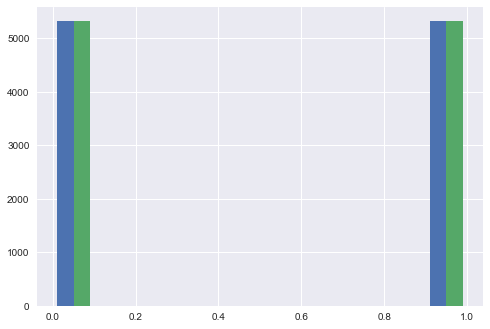

In [60]:
plt.hist(Y_pred)
plt.show()

In [62]:
Y_pred.shape

(10636, 2)